In [1]:
using Flux
using Flux.Optimise: update!
using Flux.Losses: mae, mse
using DiffEqFlux
using DiffEqSensitivity
using DifferentialEquations

using ProgressBars
using LinearAlgebra

using Random
using ProgressBars
using DelimitedFiles
using Plots, Colors, Printf, Profile

In [2]:
# using Distributed
# t = @async addprocs(8)
BLAS.set_num_threads(1)
@show Threads.nthreads();

Threads.nthreads() = 8


In [3]:
# Problem settings
function robertson(dy, y, p, t)
    k = [0.04, 3e7, 1e4] .* p
    dy[1] = -k[1]*y[1]+k[3]*y[2]*y[3]
    dy[2] =  k[1]*y[1]-k[2]*y[2]^2-k[3]*y[2]*y[3]
    dy[3] =  k[2]*y[2]^2
end

y0 = [1.0, 0.0, 0.0]
datasize = 100
tsteps = 10 .^ range(log10(1e-4), log10(1e8), length=datasize)
tspan = (0.0, tsteps[end]+1e-3)

p_true = [1, 1, 1]
weights = [1, 2e4, 1]

# solver = DifferentialEquations.CVODE_BDF()
solver = KenCarp4();
prob = ODEProblem(robertson, y0, tspan, p_true);
y_true = solve(prob, solver, p=p_true, saveat=tsteps);

In [39]:
# define the problem
scale = maximum(y_true, dims=2);
function predict_ode(p) # Our 1-layer "neural network"
    sol = solve(prob, solver, p=p, saveat=tsteps)
    pred = Array(sol)
    if sol.retcode == :Success
        nothing
    else
        println("ode solver failed")
    end
    return pred
end
function loss_ode(p; y_train=y_true) 
    return sum(abs2, (predict_ode(p) - y_train) ./ scale);
end

# settings for plots
Plots.pyplot()
Plots.resetfontsizes()
Plots.scalefontsizes(1.5)
function valid(tsteps, y_true, y_pred; title="", line1=(3, :scatter), line2=(2, :solid))
    IJulia.clear_output(true)
    h = plot(legend=false, title=title, size=(600,350), framestyle=:box, 
             palette=palette(:darktest, length(weights)))
    plot!(tsteps, (y_true .* weights)', xscale=:log10, line=line1, msw=0.0)
    plot!(tsteps, (y_pred .* weights)', xscale=:log10, line=line2)
    return h
end
# valid(tsteps, y_true, y_pred, title="test")

valid (generic function with 1 method)

In [5]:
function train(i_exp, p_init, noise_level; n_epoch=300, opt = ADAM(0.1))
    rng = MersenneTwister(0x7777777 * i_exp);
    p_pred = deepcopy(p_init);
    y_pred = predict_ode(p_pred)
    y_noise = y_true + noise_level .* (rand(rng, length(y0), length(tsteps)).-0.5) .* scale;
    
    losses_y = Vector{Float64}()
    history_p = Vector{Array{Float64}}();
    for epoch in 1:n_epoch
        grad = Flux.gradient(x -> loss_ode(x; y_train=y_noise), p_pred)[1]
        update!(opt, p_pred, grad)
        
        loss_y = loss_ode(p_pred; y_train=y_noise)
        push!(losses_y, deepcopy(loss_y))
        push!(history_p, deepcopy(p_pred))
    end
    return losses_y, history_p;
end

train (generic function with 1 method)

In [6]:
rng = MersenneTwister(0x7777777);
n_exp = 100;
n_epoch = 300;
p_init_arr = exp.(rand(rng, length(p_true), n_exp) .* 2 .- 1);
noise_level_arr = 10 .^ (rand(rng, n_exp) .* (log10(0.2) - log10(10^-3)) .+ log10(10^-3)); # [(0.1% ~ 20%)]

losses_y_exps = zeros(n_exp, n_epoch);
history_p_exps = zeros(n_exp, n_epoch, length(p_true));

In [7]:
for i in 1:100
    p_init = p_init_arr[:,i];
    noise_level = noise_level_arr[i];
    
    losses_y, history_p = train(i, p_init, noise_level; n_epoch=300);
    losses_y_exps[i,:] = deepcopy(losses_y);
    history_p_exps[i,:,:] = deepcopy(hcat(history_p...)');
    
    @show i, losses_y[end], history_p[end];
end

(i, losses_y[end], history_p[end]) = (1, 9.258070288837196e-5, [0.9994486886275558, 0.9996094769803338, 0.998566085093143])
(i, losses_y[end], history_p[end]) = (2, 7.009099786105525e-5, [1.0000670990473657, 1.0001545545076778, 1.000660184661243])
(i, losses_y[end], history_p[end]) = (3, 0.004300999955893549, [0.9967643309187306, 0.9984005271903726, 0.9974535253336182])
(i, losses_y[end], history_p[end]) = (4, 0.018717288475712367, [1.0041268720633796, 0.9958775189726562, 1.0002942479463222])
(i, losses_y[end], history_p[end]) = (5, 0.01838680500756732, [0.9910696113598209, 0.9932071048803679, 0.9812247229724639])
(i, losses_y[end], history_p[end]) = (6, 0.11053886067655756, [0.9965714829944164, 0.994667120123435, 0.9820604609796652])


┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/suxy15/.julia/packages/SciMLBase/070vZ/src/integrator_interface.jl:345


(i, losses_y[end], history_p[end]) = (7, 0.012225296675065243, [0.9970227923768378, 0.9909655838536316, 0.9875737927371614])
(i, losses_y[end], history_p[end]) = (8, 0.12693434479286175, [1.001798420314984, 0.9967353695321454, 0.9931680886455403])
(i, losses_y[end], history_p[end]) = (9, 0.0002754963772825283, [0.9992387121447998, 0.9987431072026586, 0.998024933074763])
(i, losses_y[end], history_p[end]) = (10, 0.00010143458789874288, [1.0000918117022328, 1.0004167170497364, 1.0003540799333255])
(i, losses_y[end], history_p[end]) = (11, 0.23036707814714869, [0.9863107446594082, 0.994027102494786, 0.9713668349069448])
(i, losses_y[end], history_p[end]) = (12, 0.11424809127367605, [1.0109393640448519, 1.0101422721620215, 1.0206273833847028])
(i, losses_y[end], history_p[end]) = (13, 0.4514713889620235, [0.9704762198589332, 0.9852443246830193, 1.0013515968632805])
(i, losses_y[end], history_p[end]) = (14, 0.0008521215883807768, [1.0011317003715328, 0.9995712745130764, 1.0017860204641753])

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/suxy15/.julia/packages/SciMLBase/070vZ/src/integrator_interface.jl:345


(i, losses_y[end], history_p[end]) = (55, 4.056089559101758e-5, [0.9998361884195822, 0.9999091293726399, 0.9997116288028641])
(i, losses_y[end], history_p[end]) = (56, 0.48905017162257697, [1.0007119845839805, 1.0077726927398027, 0.9988673451736089])
(i, losses_y[end], history_p[end]) = (57, 0.002542638714240637, [1.0036073988656045, 1.0013733651155026, 1.0049245529665596])
(i, losses_y[end], history_p[end]) = (58, 0.0004240727603411047, [0.9992881733264988, 0.9996419400561751, 0.9996450803637663])
(i, losses_y[end], history_p[end]) = (59, 8.343674512752888e-5, [0.9999197113891223, 1.0001130879506626, 1.0001617222957584])
(i, losses_y[end], history_p[end]) = (60, 0.0005255335079924228, [1.0000492530206, 1.0005492146558068, 0.9998485805506058])
(i, losses_y[end], history_p[end]) = (61, 5.2176164189565125e-5, [0.9997719524568083, 0.9997479247876017, 0.9994637688616821])
(i, losses_y[end], history_p[end]) = (62, 4.6513922638450456e-5, [1.0001253222799804, 0.9998909205949514, 1.00013466731

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/suxy15/.julia/packages/SciMLBase/070vZ/src/integrator_interface.jl:345


(i, losses_y[end], history_p[end]) = (76, 0.0005086951259017339, [1.0006378527352393, 1.0011937586862942, 1.0004140182327779])
(i, losses_y[end], history_p[end]) = (77, 0.00010043982128598439, [0.9996563876027125, 0.9996452222921773, 0.9999280162454395])


┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/suxy15/.julia/packages/SciMLBase/070vZ/src/integrator_interface.jl:345


(i, losses_y[end], history_p[end]) = (78, 0.02877893553790739, [1.0015455805806375, 1.0026191481521363, 1.017961437441677])
(i, losses_y[end], history_p[end]) = (79, 0.00041028784894123866, [0.9996029633988335, 0.9992204393320775, 0.9985502854159759])
(i, losses_y[end], history_p[end]) = (80, 0.0006708360105872458, [1.0000278173193844, 0.9992061821385415, 0.9998902346826158])
(i, losses_y[end], history_p[end]) = (81, 0.818103916486129, [0.9268607097577372, 0.93043008145452, 0.9373521641871024])
(i, losses_y[end], history_p[end]) = (82, 6.762897041617784e-5, [0.9998404252036459, 1.0000549488397081, 0.9999932156339719])
(i, losses_y[end], history_p[end]) = (83, 0.00017285599096834964, [1.0071642825341822, 1.00785568958652, 1.0107106127057974])
(i, losses_y[end], history_p[end]) = (84, 0.004564473237318798, [0.9990619683500109, 0.9999021135751828, 1.0036669302705896])
(i, losses_y[end], history_p[end]) = (85, 8.063564550192138e-5, [0.999912897265914, 0.9997483042408856, 0.9997680866179028

In [8]:
# h = plot(legend=false)
# for i in 1:10
#     plot!(tsteps, (y_init .* weights)', xscale=:log10, color = "#BBBBBB", alpha=0.3)
#     # plot!(tsteps, (y_pred .* weights)', xscale=:log10, color = "#BB0000", alpha=0.3)
# end
# plot!(tsteps, (y_true .* weights)', xscale=:log10)
# display(h)

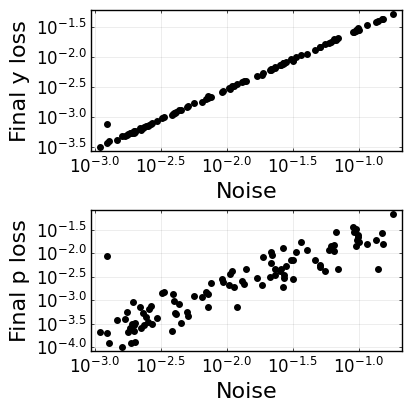

In [19]:
n_solved = 100;
losses_p_exps = zeros(n_exp, n_epoch);
errors_p_exps = zeros(n_exp, n_epoch);
for i=1:n_solved
    losses_p_exps[i,:] = sum(abs2.(history_p_exps[i,:,:] .- 1), dims=2)
    errors_p_exps[i,:] = sum(abs.(history_p_exps[i,:,:] .- 1), dims=2)./3
end

h1 = plot(xlabel="Noise", ylabel="Final y loss", size=(400,300), legend=false);
plot!(noise_level_arr[1:n_solved], (losses_y_exps[1:n_solved, end] ./ datasize ./ 3) .^ 0.5,  xscale=:log10, yscale=:log10, line=(3, :scatter), color=:black)

h2 = plot(xlabel="Noise", ylabel="Final p loss", size=(400,300), legend=false);
plot!(noise_level_arr[1:n_solved], (losses_p_exps[1:n_solved, end] ./ 3) .^ 0.5,  xscale=:log10, yscale=:log10, line=(3, :scatter), color=:black)

h = plot(h1, h2, layout=(2,1), size=(400,400), framestyle=:box)
Plots.savefig(h, "figures/Robertson_final_losses.svg")

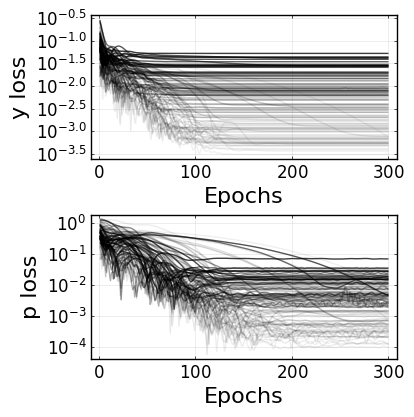

In [20]:
h1 = plot(xlabel="Epochs", ylabel="y loss", size=(400,300), legend=false);
for i=1:n_solved
    a = sqrt(noise_level_arr[i] / 10^-0.5)
    plot!(1:n_epoch, (losses_y_exps[i, :] ./ datasize ./ 3) .^ 0.5, yscale=:log10, line=(1, :solid), alpha=a, color=:black)
end

h2 = plot(xlabel="Epochs", ylabel="p loss", size=(400,300), legend=false);
for i=1:n_solved
    a = sqrt(noise_level_arr[i] / 10^-0.5)
    plot!(1:n_epoch, (losses_p_exps[i, :] ./ 3) .^ 0.5, yscale=:log10, line=(1, :solid), alpha=a, color=:black)
end
h = plot(h1, h2, layout=(2,1), size=(400,400), framestyle=:box)
Plots.savefig(h, "figures/Robertson_losses.svg")

In [11]:
# i=1;
# p_pred = p_init_arr[:,i];
# ps = Flux.params(p_pred)
# function loss()
#     return sum(abs2, (predict_ode(p_pred) - y_true) ./ scale);
# end
# opt = ADAM(0.1)
# data = Iterators.repeated((), 300);
# @time Flux.train!(loss, ps, data, opt);
# # about 67 secs; manualy 80 secs

In [12]:
# single case 1: without noise
i = 100;
p_init = p_init_arr[:,i];
noise_level = 0.;

n0_losses_y, n0_history_p = train(i, p_init, noise_level; n_epoch=300);

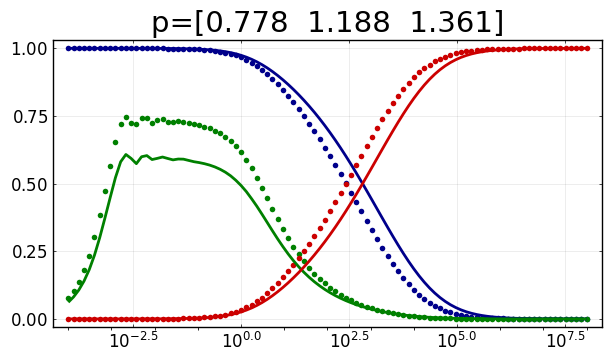

In [64]:
i = 100;
p_init = p_init_arr[:,i];
noise_level = 0.;

rng = MersenneTwister(0x7777777 * i);
y_noise = y_true + noise_level .* (rand(rng, length(y0), length(tsteps)).-0.5) .* scale;
p_pred = n0_history_p[end]

y_init = predict_ode(p_init)
h = valid(tsteps, y_noise, y_init; title="$(@sprintf("p=[%.3f  %.3f  %.3f]", p_init[1], p_init[2], p_init[3]))")
Plots.savefig(h, "figures/Robertson_no_noise_init.svg")

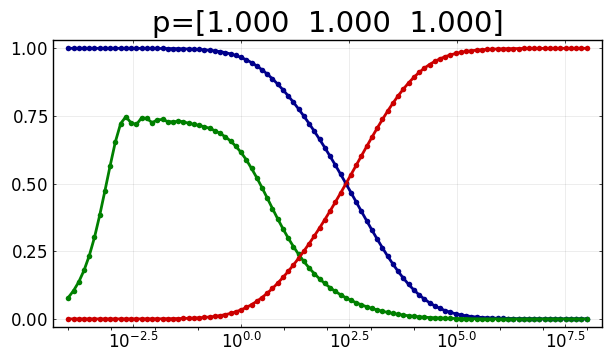

In [65]:
y_pred = predict_ode(p_pred)
valid(tsteps, y_noise, y_pred)
h = valid(tsteps, y_noise, y_pred; title="$(@sprintf("p=[%.3f  %.3f  %.3f]", p_pred[1], p_pred[2], p_pred[3]))")
Plots.savefig(h, "figures/Robertson_no_noise_pred.svg")

In [15]:
# single case 2: 30% noise
i=100
p_init = p_init_arr[:,i];
noise_level = 0.1;

n3_losses_y, n3_history_p = train(i, p_init, noise_level; n_epoch=300);

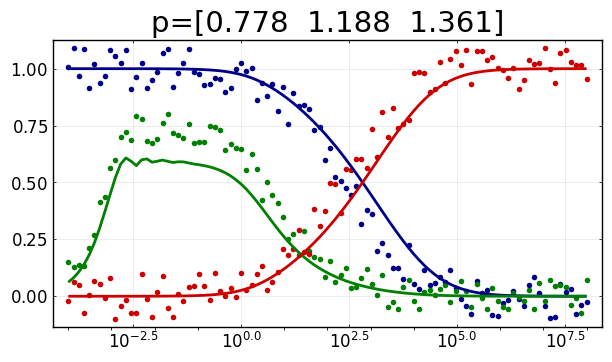

In [63]:
i=100
p_init = p_init_arr[:,i];
noise_level = 0.2;

rng = MersenneTwister(0x7777777 * i);
y_noise = y_true + noise_level .* (rand(rng, length(y0), length(tsteps)).-0.5) .* scale;
p_pred = n3_history_p[end]

y_init = predict_ode(p_init)
h = valid(tsteps, y_noise, y_init; title="$(@sprintf("p=[%.3f  %.3f  %.3f]", p_init[1], p_init[2], p_init[3]))")
Plots.savefig(h, "figures/Robertson_0.2_noise_init.svg")

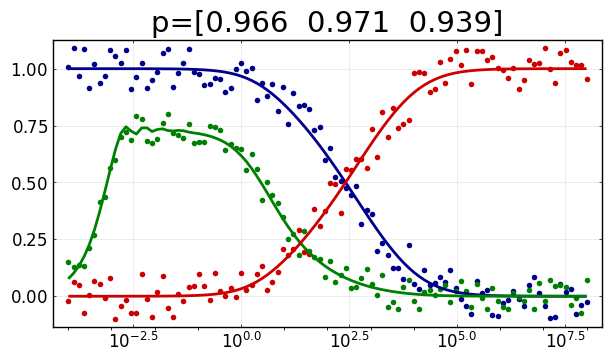

In [62]:
y_pred = predict_ode(p_pred)
valid(tsteps, y_noise, y_pred)
h = valid(tsteps, y_noise, y_pred; title="$(@sprintf("p=[%.3f  %.3f  %.3f]", p_pred[1], p_pred[2], p_pred[3]))")
Plots.savefig(h, "figures/Robertson_0.2_noise_pred.svg")

In [68]:
@show sqrt(sum((n0_history_p[end] .- 1).^2 / 3));
@show sqrt(sum((n3_history_p[end] .- 1).^2 / 3));

sqrt(sum((n0_history_p[end] .- 1) .^ 2 / 3)) = 1.9052450886761907e-5
sqrt(sum((n3_history_p[end] .- 1) .^ 2 / 3)) = 0.043682683644896775
